In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun august 21 14:35:15 2016
@author: Sidon
"""
%matplotlib inline
import pandas as pd
import numpy as np
from collections import OrderedDict
from tabulate import tabulate, tabulate_formats
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

from sklearn import tree
from io import StringIO
from IPython.display import Image
import pydotplus
import itertools

# Variables Descriptions
INCOME = "2010 Gross Domestic Product per capita in constant 2000 US$"
ALCOHOL = "2008 alcohol consumption (liters, age 15+)"
LIFE = "2011 life expectancy at birth (years)"

# os.chdir('/home/sidon/dev/coursera')
out = StringIO()

# bug fix for display formats to avoid run time errors
pd.set_option('display.float_format', lambda x:'%f'%x)

# Load from CSV
data0 = pd.read_csv('~/dev/coursera/gapminder.csv', skip_blank_lines=True,
                     usecols=['country','incomeperperson',
                              'alcconsumption','lifeexpectancy'])


In [2]:
def to_num(list, data):
    for dt in list :
        data[dt] = pd.to_numeric(data[dt], 'errors=coerce')
    return data    
        

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

In [4]:
# Rename columns for clarity                                    
data0.columns = ['country','income','alcohol','life']

# converting to numeric values and parsing (numeric invalids=NaN)
data0 = to_num( ('income','alcohol','life'), data0 )

# Remove rows with nan values
data0 = data0.dropna(axis=0, how='any')

# Copy dataframe for preserve original
data1 = data0.copy()

In [5]:
# Mean, Min and Max of life expectancy
meal = data1.life.mean()
minl = data1.life.min() 
maxl = data1.life.max()

# Create categorical response variable life (Two levels based on mean)
data1['life'] = pd.cut(data0.life,[np.floor(minl),meal,np.ceil(maxl)], labels=['<=69','>69'])
data1['life'] = data1['life'].astype('category')

In [6]:
# Mean, Min and Max of alcohol
meaa = data1.alcohol.mean()
mina = data1.alcohol.min() 
maxa = data1.alcohol.max()

# Categoriacal explanatory variable (Two levels based on mean) 
data1['alcohol'] = pd.cut(data0.alcohol,[np.floor(mina),meaa,np.ceil(maxa)], 
                          labels=[0,1])

cat1 = pd.qcut(data0.alcohol,5).cat.categories
data1["alcohol"] = pd.qcut(data0.alcohol,5,labels=['0','1','2','3','4'])
data1["alcohol"] = data1["alcohol"].astype('category')


In [7]:
# Mean, Min and Max of income
meai = data1.income.mean()
mini = data1.income.min() 
maxi = data1.income.max()

# Categoriacal explanatory variable (Two levels based on mean) 
data1['income'] = pd.cut(data0.income,[np.floor(mini),meai,np.ceil(maxi)], 
                          labels=[0,1])
data1["income"] = data1["income"].astype('category')

In [8]:
data1 = to_num( ('alcohol', 'income'), data1 )
#print (predictors)

In [9]:
predictors = data1[['alcohol', 'income']]
targets = data1.life
pred_train, pred_test, tar_train, tar_test  =   train_test_split(predictors, targets, test_size=.4)

#Build model on training data
clf = DecisionTreeClassifier()
clf = clf.fit(pred_train,tar_train)

predictions=clf.predict(pred_test)

Confusion matrix, without normalization
[[18 12]
 [ 6 33]]


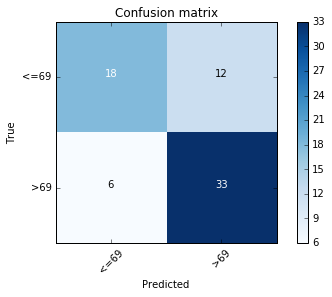

In [10]:
confusion_matrix = sklearn.metrics.confusion_matrix(tar_test,predictions)
plot_confusion_matrix(confusion_matrix,['<=69','>69'])

This graph represents the confusion matrix, that shows the correct and incorrect classifications of the decision tree, the labels means the life expectancy greater and less than 69 years, the horizontal labels are the predictions and the vertical are the reference (true).
the main diagonal: 16 and 34 represent the number of true negative and true positive for life expectancy and the other diagonal (values 7 and 12) represents the numbers of false negative and false positive respectively.

In [11]:
accuracy = sklearn.metrics.accuracy_score(tar_test, predictions)
print ('Accuracy Score: ', accuracy,'\n')

Accuracy Score:  0.739130434783 



The accuracy score is approximately 0.72, this suggests that the decision tree model has classified 72% of the sample as either countrie with life expectancy greater or less than the mean (69 years).

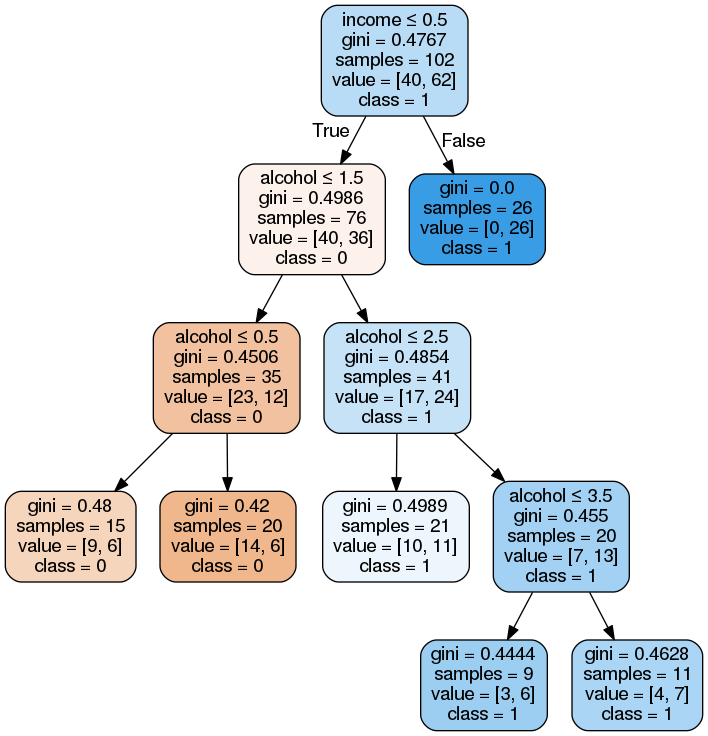

In [12]:
tree.export_graphviz(clf, out_file=out, feature_names=['alcohol', 'income'],class_names=['0','1'], 
                     filled=True, rounded=True, special_characters=True)

graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

In [14]:
print (data0.mean())

income    7006.359798
alcohol      6.784094
life        69.385737
dtype: float64


In [15]:
print (cat1)

Index(['[0.05, 1.87]', '(1.87, 4.72]', '(4.72, 7.32]', '(7.32, 11.1]',
       '(11.1, 23.01]'],
      dtype='object')


Here, the target is the life (my binary categorical variable) and alcohol consumption and income levels as the predictor or explanatory variables. The result tree starts with the split on income variable, my second explanatory variable. This binary variable has values of zero (0) representing income level less than or equals the mean (US$ 7.006,00) and value one (1) representing income greater than the mean. The resulting tree starts with the split on income variable. 
In the first split (1) we can see that 26 countries have the life expectancy and income levels greater than the mean (A) and the other 76 countries have the life expectancy less than the mean. The second split (2), splits in the other 2 internal nodes according to consumption alcohol levels and so on. 

Through internal nodes 2, 4 and 5 and the leaves D, E, and F, we can see that the majority of countries with the life expectancy greater than the mean (Class 1) has the alcohol consumption between 2.5 and 3.5 liters per year (11 countries in leaf D)

### Conclusion
It is easy to note the significance of the variable income. In the first split, we see that all countries that have income level greater than 0.5 (The mean) have the life expectancy greater than the mean (A - Blue leaf), independently of the consumption alcohol level. In the other hand, although the differences are subtle we can see than the among the countries that have income levels less than the mean, those that have alcohol consumption between 2.5 and 3.5 have the life expectancy greater than the mean.